# Sensitivity Studies

Compare with:

+ Arc
+ Act 1 & 2
+ Demo (Pulsed and SS)

// also adds prototype reactor designs (scylla and charybdis)

## 0.0 Bootup Notebook

In [1]:
# addprocs(12)

# @everywhere 

using Fussy

Main.IJulia.set_current_module(Fussy)

return

## 1.0 Set Defaults

In [2]:
cur_decks = [
    :proteus, # pulsed
    :charybdis, # steady state
    :arc, :act_1, :act_2,
    :demo_steady, :demo_pulsed
]
  
cur_params = [ 
    :H, :Q, :wave_theta,
    :epsilon, :kappa_95, :delta_95,
    :nu_n, :nu_T, :l_i,
    :N_G, :f_D, :Z_eff,
    :max_beta_N, :max_q_95, :max_P_W, 
    :eta_CD, :B_CS, :tau_FT
]

return

## 2.0 Define Make Function

In [3]:
function make_studies(cur_param)
    tmp_studies = Dict()

    for cur_deck in cur_decks
        println(cur_deck)
        
        if cur_deck == :demo_pulsed || cur_deck == :proteus || cur_deck == :demo_steady
            is_consistent = false
        else
            is_consistent = true
        end
        
        cur_study = Study(
            cur_param, deck=cur_deck, is_consistent=is_consistent, is_fast=false, sensitivity=1.0, num_points=41, is_parallel=true
        )
        
        tmp_studies[cur_deck] = cur_study
        sleep(0.25)
    end

    println("done.")

    tmp_studies
end

return

## 3.0 Get Data

In [4]:
using FileIO
using JLD2

In [5]:
using Plots

In [12]:
# plotlyjs()
gr()

Plots.GRBackend()

In [13]:
cur_file = "../data/sensitivities.jld2"

# cur_studies = nothing
# try
    cur_studies = load(cur_file, "cur_studies")
# catch
#     cur_studies = Dict()
# end

latent_error = nothing
for cur_param in cur_params
    haskey(cur_studies, cur_param) && continue
    println("> ", cur_param, "\n")
    try
        cur_studies[cur_param] = make_studies(cur_param)
    catch cur_error
        latent_error = cur_error
        break
    end
    jldopen(cur_file, "w") do work_dict
        work_dict["cur_studies"] = cur_studies
    end
end

( latent_error == nothing ) || rethrow(latent_error)

return

## 4.0 Setup for Plots

In [14]:
cur_fields = [ 
    "T_bar", "n_bar", "I_P", "B_0", "R_CS",
    "P_F", "f_IN", "f_BS", "f_CD", "W_M", "cost", "eta_CD",
    "norm_q_95", "norm_P_E", "norm_P_W", "b", "c", "d", "P_ohmic"
]

sort!(cur_fields)

unshift!(cur_fields, "R_0")

return

In [17]:
using Plots

gr()

Plots.GRBackend()

In [18]:
using Interact
using StringCases
using DataStructures

## 5.0 Make Plot GUI

Interact.Options{:ToggleButtons,Symbol}(21: "input-13" = H Symbol , "xvar", :H, "H", 1, Interact.OptionDict(DataStructures.OrderedDict("H"=>:H,"Q"=>:Q,"wave_theta"=>:wave_theta,"epsilon"=>:epsilon,"kappa_95"=>:kappa_95,"delta_95"=>:delta_95,"nu_n"=>:nu_n,"nu_T"=>:nu_T,"l_i"=>:l_i,"N_G"=>:N_G…), Dict(:tau_FT=>"tau_FT",:f_D=>"f_D",:max_beta_N=>"max_beta_N",:max_q_95=>"max_q_95",:kappa_95=>"kappa_95",:eta_CD=>"eta_CD",:epsilon=>"epsilon",:nu_n=>"nu_n",:Q=>"Q",:delta_95=>"delta_95"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:ToggleButtons,String}(23: "input-14" = R_0 String , "yvar", "R_0", "R_0", 1, Interact.OptionDict(DataStructures.OrderedDict("R_0"=>"R_0","B_0"=>"B_0","I_P"=>"I_P","P_F"=>"P_F","P_ohmic"=>"P_ohmic","R_CS"=>"R_CS","T_bar"=>"T_bar","W_M"=>"W_M","b"=>"b","c"=>"c"…), Dict("W_M"=>"W_M","I_P"=>"I_P","c"=>"c","R_0"=>"R_0","B_0"=>"B_0","b"=>"b","n_bar"=>"n_bar","eta_CD"=>"eta_CD","f_IN"=>"f_IN","norm_P_W"=>"norm_P_W"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:ToggleButtons,Symbol}(25: "input-15" = proteus Symbol , "deck", :proteus, "proteus", 1, Interact.OptionDict(DataStructures.OrderedDict("proteus"=>:proteus,"charybdis"=>:charybdis,"arc"=>:arc,"act_1"=>:act_1,"act_2"=>:act_2,"demo_steady"=>:demo_steady,"demo_pulsed"=>:demo_pulsed), Dict(:act_1=>"act_1",:proteus=>"proteus",:demo_steady=>"demo_steady",:charybdis=>"charybdis",:act_2=>"act_2",:arc=>"arc",:demo_pulsed=>"demo_pulsed")), Any[], Any[], true, "horizontal", true)

Interact.Checkbox(27: "input-16" = true Bool , "enable_R_0", true)

Interact.Checkbox(28: "input-17" = true Bool , "enable_B_0", true)

Interact.Checkbox(29: "input-18" = true Bool , "enable_main", true)

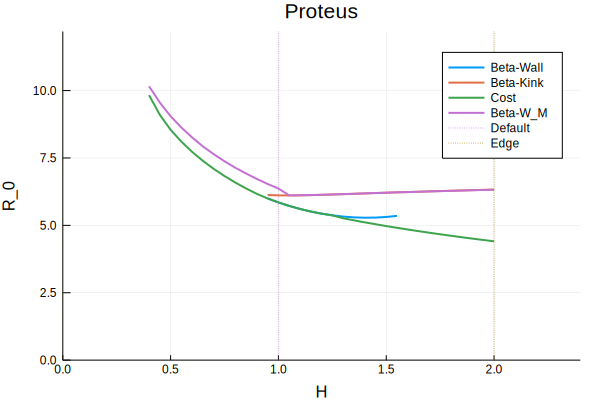

In [20]:
@manipulate for xvar in cur_params, yvar in cur_fields, deck in cur_decks, enable_R_0=true, enable_B_0=true, enable_main=true
    cur_study = cur_studies[xvar][deck]

    work_dict = OrderedDict()
    
    work_dict["Wall"] = cur_study.wall_reactors
    work_dict["Kink"] = cur_study.kink_reactors
    work_dict["Cost"] = cur_study.cost_reactors
    
    work_dict["W_M"] = cur_study.W_M_reactors
    
    for (cur_key, cur_value) in work_dict
        work_dict[cur_key] = filter(work_reac -> work_reac.is_valid, cur_value)
    end
        
    max_yy = 0
    
    plot()
    for (cur_index, (cur_key, cur_value)) in enumerate(work_dict)
        isempty(cur_value) && continue
        cur_xx = map(cur_reactor -> safe_get(cur_reactor, Symbol(xvar)), cur_value) 
        cur_yy = map(cur_reactor -> safe_get(cur_reactor, Symbol(yvar)), cur_value) 

        max_yy = max(max_yy, maximum(cur_yy))
        
        cur_style = length(split(cur_key, " ")) > 1 ? :dash : :solid
        cur_width = length(split(cur_key, " ")) > 1 ? 1 : 2
        
        cur_label = ( cur_key == "Cost" ) ? "Cost" : "Beta-$(cur_key)"
        
        plot_func = length(cur_xx) == 1 ? scatter! : plot!
        if length(split(cur_key, " ")) > 1 
            if endswith(cur_key, "R_0")
                cur_label = "R_0 = $(round(first(cur_value).R_0,1))"
                enable_R_0 && plot_func(cur_xx, cur_yy, label=cur_label, color=cur_index, style=:dash, palette=:grays)
            else
                cur_label = "B_0 = $(round(first(cur_value).B_0,1))"
                enable_B_0 && plot_func(cur_xx, cur_yy, label=cur_label, color=cur_index, style=:dash, palette=:greens)
            end
        else
            enable_main && plot_func(cur_xx, cur_yy, label=cur_label, color=cur_index, width=2)
        end
        
    end
    plot!()
    
    cur_bot_value = (1-cur_study.sensitivity)*cur_study.default
    cur_top_value = (1+cur_study.sensitivity)*cur_study.default
    
    plot!(
        [cur_study.default,cur_study.default],
        [0,max_yy*1.25], 
        label="Default", style=:dot, color=4, lineopacity=0.55, width=1.5
    )
    
    plot!(
        [cur_bot_value,cur_bot_value,NaN,cur_top_value,cur_top_value],
        [0,max_yy*1.25,NaN,0,max_yy*1.25], 
        label="Edge", style=:dot, color=5, lineopacity=0.55, width=1.5
    )
    
    max_xx = cur_top_value
    
    xlims!(0, max_xx * 1.2)
    ylims!(0, max_yy * 1.2)

    xlabel!(string(xvar))
    ylabel!(yvar)

    cur_title = join(map(capitalize, split(string(deck), "_")), " ")
    title!(cur_title)
    
    plot!(dpi=400)
end